# Back to the Reddit dataset

After we:

1. Tested few different personality-prediction-by-text tools
2. Generated textual content that highly correlates with high/low openness
3. Trained a logistic regression model to classify texts to high-openness / low-openness
4. Compared the trained model with other models we've trained as well as with the existing tools (1)

We've chose the logistic-regression model that we've trained as the model to work with on the Reddit dataset that we've gathered


## Filter out short texts

To effectively use the model, we need to use only long-enough texts. <br>
We set the threshold as the average length of texts used to train the model, which is **40** tokens.


### Median | AVG Length of posts per community


In [2]:
import os
import json
import statistics

directory = "./data/detailed_filtered_data"
threshold = 40

print(
    "[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: "
)
for root, dirs, files in os.walk(directory):
    for folder in dirs:
        counter_in_genre = []
        folder_path = os.path.join(root, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                file_path = os.path.join(folder_path, file)
                with open(file_path, "r") as json_file:
                    data_for_stat_tests = json.load(json_file)
                    counter = 0
                    for vector_file_name in data_for_stat_tests.keys():
                        for sub in data_for_stat_tests.get(vector_file_name, {}).get(
                            "submissions"
                        ):
                            if len(sub.get("title", "").split()) >= threshold:
                                counter += 1
                            if len(sub.get("body", "").split()) >= threshold:
                                counter += 1
                        for comment in data_for_stat_tests.get(
                            vector_file_name, {}
                        ).get("comments"):
                            if len(comment.get("body", "").split()) >= threshold:
                                counter += 1
                    counter_in_genre.append(counter)
        if counter_in_genre:
            print(
                folder,
                "[",
                statistics.median(counter_in_genre),
                "|",
                statistics.mean(counter_in_genre),
                "]",
            )

[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: 
indieheads [ 35.0 | 84.467 ]
hiphopheads [ 82.0 | 121.983 ]
Metal [ 53.5 | 103.118 ]
electronicmusic [ 43.0 | 97.761 ]
classicalmusic [ 117.0 | 172.252 ]


### Process the data as a DataFrame


In [3]:
import pandas as pd
import os
import json
from tqdm import tqdm

df = pd.DataFrame(columns=["community", "user_name",
                  "user_texts", "#_of_long_texts"])


def process_files(community, df):
    threshold = 40
    directory = f"./data/detailed_filtered_data/texts/{community}"
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".json"):
            user_texts = []
            with open(os.path.join(directory, filename), "r") as f:
                data = json.load(f)
                for key in data:
                    for submission in data[key].get("submissions", []):
                        title = submission.get("title", "")
                        body = submission.get("body", "")
                        if len(title.split()) >= threshold:
                            user_texts.append(title)
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
                    for submission in data[key].get("comments", []):
                        body = submission.get("body", "")
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
            if len(user_texts) == 0:
                continue
            user_name = filename.split(".json")[0]
            new_row = pd.DataFrame(
                {
                    "community": community,
                    "user_name": [user_name],
                    "user_texts": [user_texts],
                    "#_of_long_texts": [len(user_texts)],
                }
            )
            df = pd.concat([df, new_row], ignore_index=True)
    return df


communities = [
    "classicalmusic",
    "electronicmusic",
    "hiphopheads",
    "indieheads",
    "Metal",
]

for vector_file_name in communities:
    df = pd.concat([df, process_files(vector_file_name, df)])
print("Done processing texts :)")

100%|██████████| 1000/1000 [00:01<00:00, 930.38it/s]

Done processing texts :)


#### De-Duplication


In [4]:
def deduplicate_texts(df):
    exploded_df = df.explode("user_texts")
    exploded_df = exploded_df.drop_duplicates(subset="user_texts")
    return exploded_df


df = deduplicate_texts(df)
print("After dedeuplication there are", format(
    len(df), ","), "unique texts in total")

After dedeuplication there are 575,816 unique texts in total


In [5]:
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

communities_dfs = [
    classicalmusic_df,
    electronicmusic_df,
    hiphopheads_df,
    indieheads_df,
    metal_df,
]

print(
    "Number of texts left after deduplication per community:",
    "\nClassicalmusic:",
    format(len(classicalmusic_df), ","),
    "\nElectronicmusic:",
    format(len(electronicmusic_df), ","),
    "\nHiphopheads:",
    format(len(hiphopheads_df), ","),
    "\nIndieheads:",
    format(len(indieheads_df), ","),
    "\nMetal:",
    format(len(metal_df), ","),
)

Number of texts left after deduplication per community: 
Classicalmusic: 170,251 
Electronicmusic: 97,063 
Hiphopheads: 121,538 
Indieheads: 84,314 
Metal: 102,650


In [6]:
classicalmusic_counts = classicalmusic_df["user_name"].value_counts()
electronicmusic_counts = electronicmusic_df["user_name"].value_counts()
hiphopheads_counts = hiphopheads_df["user_name"].value_counts()
indieheads_counts = indieheads_df["user_name"].value_counts()
metal_counts = metal_df["user_name"].value_counts()


print("Median and Mean of texts-count per user in each community after deduplication:")
print(
    "classicalmusic: Median =",
    classicalmusic_counts.median(),
    " | Mean =",
    round(classicalmusic_counts.mean(), 2),
)
print(
    "electronicmusic: Median =",
    electronicmusic_counts.median(),
    " | Mean =",
    round(electronicmusic_counts.mean(), 2),
)
print(
    "hiphopheads: Median =",
    hiphopheads_counts.median(),
    " | Mean =",
    round(hiphopheads_counts.mean(), 2),
)
print(
    "indieheads: Median =",
    indieheads_counts.median(),
    " | Mean =",
    round(indieheads_counts.mean(), 2),
)
print(
    "metal: Median =", metal_counts.median(), " | Mean =", round(metal_counts.mean(), 2)
)

Median and Mean of texts-count per user in each community after deduplication:
classicalmusic: Median = 118.5  | Mean = 173.37
electronicmusic: Median = 60.5  | Mean = 109.55
hiphopheads: Median = 83.0  | Mean = 122.39
indieheads: Median = 52.0  | Mean = 96.8
metal: Median = 58.0  | Mean = 107.94


# Vectorize all Redditors texts


## Vectorize Text method


In [7]:
from sentence_transformers import SentenceTransformer
from typing import List, Union
from torch import Tensor
from numpy import ndarray


def vectorize_text(
    text, model: SentenceTransformer, batch_size=12, show_progress_bar=False
) -> Union[List[Tensor], ndarray, Tensor]:
    return model.encode(
        text, show_progress_bar=show_progress_bar, batch_size=batch_size
    )

/Users/eliran/Personal/dev/Musical-Preferences-And-Textual-Expression/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
df = df.reset_index(drop=True)
df.head()

,community,user_name,user_texts,#_of_long_texts
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339


## `all-MiniLM-L6-v2`

Working with the all-MiniLM-L6-v2 model is much faster, so all vectorization is done at once in this case


### Vectorize


In [8]:
tqdm.pandas()
model = SentenceTransformer("all-MiniLM-L6-v2")

df["vector"] = df["user_texts"].progress_apply(
    lambda x: vectorize_text(x, model) if not isinstance(x, float) else []
)

100%|██████████| 575816/575816 [2:13:16<00:00, 72.01it/s]  


### Re-load


In [ ]:
import pickle

with open("mini_reddit_data_vectorized.pkl", "rb") as f:
    df["vector"] = pickle.load(f)

## `intfloat/e5-large-v2`

On the other hand, the intfloat/e5-large-v2 model is much slower, so vectorization is done in chunks and persisted the H5 files


### Vectorize


In [8]:
import h5py
import numpy as np
from tqdm import tqdm

model = SentenceTransformer("intfloat/e5-large-v2")


def vectorize_community_data(community_name: str, df: pd.DataFrame):
    file_path = f"data/detailed_filtererd_data/vectors/{community_name}.h5"
    compression = "lzf"
    estimated_rows = len(df)

    with h5py.File(file_path, "a") as f:
        if "vectors" not in f:
            dataset = f.create_dataset(
                "vectors",
                (estimated_rows, model.get_sentence_embedding_dimension()),
                dtype=np.float32,
                compression=compression,
            )
            print("Dataset shape:", dataset.shape)
        else:
            dataset = f["vectors"]

        i = 0
        progress_bar = tqdm(total=estimated_rows, desc="Vectorizing texts")
        for _, row in df.iterrows():
            vector = vectorize_text(row["user_texts"], model)
            dataset[i] = vector
            i += 1
            progress_bar.update(1)
        progress_bar.close()


vectorize_community_data("metal", metal_df)
vectorize_community_data("classicalmusic", classicalmusic_df)
vectorize_community_data("electronicmusic", electronicmusic_df)
vectorize_community_data("hiphopheads", hiphopheads_df)
vectorize_community_data("indieheads", indieheads_df)

Dataset shape: (170251, 1024)


Vectorizing texts: 100%|██████████| 170251/170251 [10:02:07<00:00,  4.71it/s] 


### Re-load


In [10]:
import h5py

vector_file_names = ["classical", "electronic", "hiphopheads", "indieheads", "metal"]

for vector_file_name, df in zip(vector_file_names, communities_dfs):
    with h5py.File(
        f"data/detailed_filtered_data/vectors/{vector_file_name}.h5", "r"
    ) as f:
        dataset = f["vectors"]
        df["vector"] = dataset[:].tolist()
df = pd.concat(communities_dfs, ignore_index=True)

# Show Sample


In [11]:
df.head()

,community,user_name,user_texts,#_of_long_texts,vector
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,..."
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0..."
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.008903076872229576, -0.05069487541913986, ..."
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.04738666117191315, -0.053208597004413605, 0..."
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[0.007831799797713757, -0.0637780949473381, 0...."


# Back to Logistic regression


## `all-MiniLM-L6-v2`


### Load the model


In [9]:
import pickle
from sklearn.linear_model import LogisticRegression

with open("models/mini_gpt_and_myPersonality.pkl", "rb") as f:
    mini_gpt_and_myPersonality: LogisticRegression = pickle.load(f)

### Predict-Probablily

Use the model to Predict-Probablily for every user texts to be in high vs low openness classes


In [ ]:
df["OPN_proba"] = df["vector"].progress_apply(
    lambda x: mini_gpt_and_myPersonality.predict_proba(x.reshape(1, -1))
)

## `intfloat/e5-large-v2`


### Load the model


In [12]:
import pickle
from sklearn.linear_model import LogisticRegression

with open("models/gpt_and_myPersonality.pkl", "rb") as f:
    gpt_and_myPersonality: LogisticRegression = pickle.load(f)

/Users/eliran/Personal/dev/Musical-Preferences-And-Textual-Expression/.venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.2 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Predict-Probablily

Use the model to Predict-Probablily for every user texts to be in high vs low openness classes


In [15]:
import numpy as np

df["OPN_proba"] = df["vector"].apply(
    lambda x: gpt_and_myPersonality.predict_proba(np.array(x).reshape(1, -1))
)

In [16]:
df.groupby("community").head(5)

,community,user_name,user_texts,#_of_long_texts,vector,OPN_proba
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,...","[[0.8262392460938337, 0.17376075390616627]]"
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0...","[[0.589807086022424, 0.410192913977576]]"
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.008903076872229576, -0.05069487541913986, ...","[[0.6808525955323554, 0.31914740446764456]]"
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.04738666117191315, -0.053208597004413605, 0...","[[0.8330441760356234, 0.16695582396437655]]"
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[0.007831799797713757, -0.0637780949473381, 0....","[[0.8114507670548725, 0.18854923294512746]]"
170251,electronicmusic,headphase,"This Monday, June 12, r/BedStuy will become un...",305,"[0.011666242964565754, -0.035366132855415344, ...","[[0.6954901085111163, 0.30450989148888374]]"
170252,electronicmusic,headphase,Rant incoming.. I know this isn't just a BedSt...,305,"[0.014536317437887192, -0.04572702944278717, 0...","[[0.6365041189816335, 0.3634958810183665]]"
170253,electronicmusic,headphase,"Hi everyone, first off thanks for your patienc...",305,"[0.0012467063497751951, -0.03821362182497978, ...","[[0.6518456238961388, 0.34815437610386124]]"
170254,electronicmusic,headphase,"Next Monday, June 12th, r/aviationmemes will b...",305,"[0.008768602274358273, -0.047856613993644714, ...","[[0.6761544928043506, 0.32384550719564936]]"
170255,electronicmusic,headphase,"Hi all, as of today a new post flair labeled \...",305,"[0.02191307209432125, -0.044258877635002136, -...","[[0.6002359985816053, 0.39976400141839474]]"


### Calculate the average predicted probability for every user's openness classes (high vs low openness)


In [17]:
average_opn_proba_0 = df.groupby("user_name")["OPN_proba"].apply(
    lambda x: x.apply(lambda y: y[0][0]).mean()
)
df["probability_for_high_openness"] = df["user_name"].map(average_opn_proba_0)

In [18]:
df.head()

,community,user_name,user_texts,#_of_long_texts,vector,OPN_proba,probability_for_high_openness
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,...","[[0.8262392460938337, 0.17376075390616627]]",0.740002
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0...","[[0.589807086022424, 0.410192913977576]]",0.740002
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.008903076872229576, -0.05069487541913986, ...","[[0.6808525955323554, 0.31914740446764456]]",0.740002
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.04738666117191315, -0.053208597004413605, 0...","[[0.8330441760356234, 0.16695582396437655]]",0.740002
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[0.007831799797713757, -0.0637780949473381, 0....","[[0.8114507670548725, 0.18854923294512746]]",0.740002


# High OPN Probability

AVG and Median Per Genre


## `intfloat/e5-large-v2`


In [20]:
mean_values = df.groupby("community")[["probability_for_high_openness"]].mean()
median_values = df.groupby("community")[
    ["probability_for_high_openness"]].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)

Mean values:
                 probability_for_high_openness
community                                     
Metal                                 0.685465
classicalmusic                        0.707373
electronicmusic                       0.675736
hiphopheads                           0.659340
indieheads                            0.677143

Median values:
                 probability_for_high_openness
community                                     
Metal                                 0.686074
classicalmusic                        0.702226
electronicmusic                       0.675754
hiphopheads                           0.660815
indieheads                            0.676557


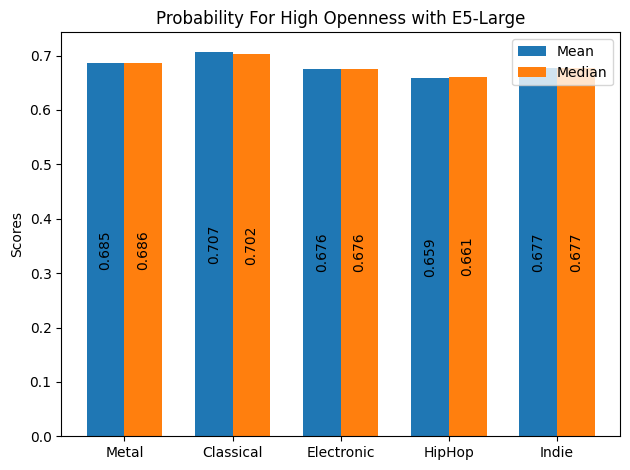

In [47]:
import matplotlib.pyplot as plt
import numpy as np

means = [0.685465, 0.707373, 0.675736, 0.659340, 0.677143]
medians = [0.686074, 0.702226, 0.675754, 0.660815, 0.676557]


def plot_bars_for_high_openness_probability(means: list[float], medians: list[float], model_name: str):
    labels = ['Metal', 'Classical', 'Electronic', 'HipHop', 'Indie']
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, means, width, label='Mean')
    rects2 = ax.bar(x + width/2, medians, width, label='Median')

    ax.set_ylabel('Scores')
    ax.set_title(f'Probability For High Openness with {model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height/2),
                        xytext=(0, 0),  # no offset
                        textcoords="offset points",
                        ha='center', va='center', rotation=90)

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()


plot_bars_for_high_openness_probability(means, medians, model_name="E5-Large")

## `all-MiniLM-L6-v2`


In [ ]:
mean_values = df.groupby("community")[["average_opn_proba_0"]].mean()
median_values = df.groupby("community")[["average_opn_proba_0"]].median()

print("Mean values:")
print(mean_values)

print("\nMedian values:")
print(median_values)

Mean values:
                 average_opn_proba_0  average_opn_proba_1
community                                                
Metal                       0.688614             0.311386
classicalmusic              0.716958             0.283042
electronicmusic             0.684451             0.315549
hiphopheads                 0.681755             0.318245
indieheads                  0.689712             0.310288

Median values:
                 average_opn_proba_0  average_opn_proba_1
community                                                
Metal                       0.688207             0.311793
classicalmusic              0.713479             0.286521
electronicmusic             0.682555             0.317445
hiphopheads                 0.680303             0.319697
indieheads                  0.688481             0.311519


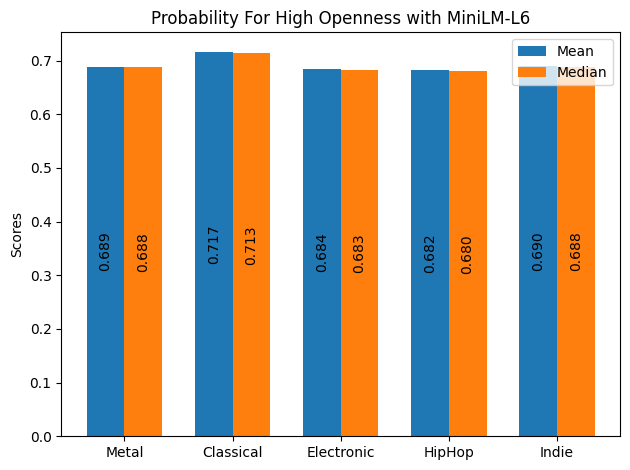

In [48]:
means = [0.688614, 0.716958, 0.684451, 0.681755, 0.689712]
medians = [0.688207, 0.713479, 0.682555, 0.680303, 0.688481]
plot_bars_for_high_openness_probability(means, medians, model_name="MiniLM-L6")

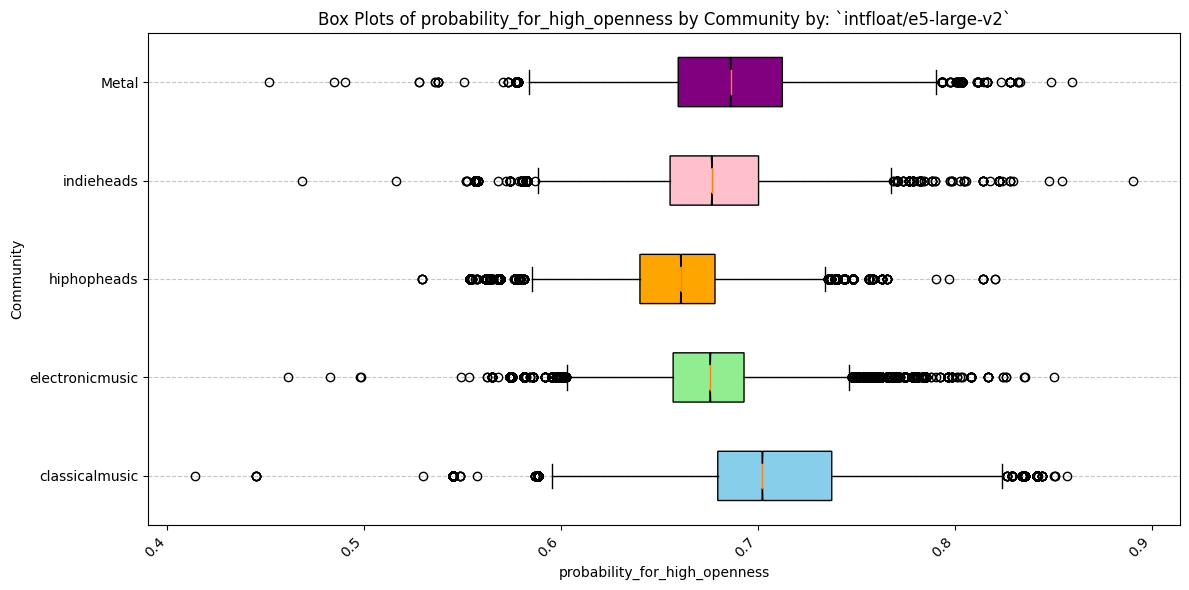

In [23]:
import pandas as pd
import matplotlib.pyplot as plt


def draw_proba_box_plot(class_name: str):
    plt.figure(figsize=(12, 6))

    bp = plt.boxplot(
        [df[df["community"] == c][class_name] for c in df["community"].unique()],
        notch=True,
        vert=False,
        labels=df["community"].unique(),
        patch_artist=True,
    )

    for box, color in zip(
        bp["boxes"], ["skyblue", "lightgreen", "orange", "pink", "purple"]
    ):
        box.set_facecolor(color)

    plt.xlabel(class_name)
    plt.ylabel("Community")
    plt.title(f"Box Plots of {class_name} by Community by: `intfloat/e5-large-v2`")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


draw_proba_box_plot("probability_for_high_openness")

In [26]:
print("Example of the dataframe we have now:")
df.head()

Example of the dataframe we have now:


,community,user_name,user_texts,#_of_long_texts,vector,probability_for_high_openness
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,...",0.740002
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0...",0.740002
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.008903076872229576, -0.05069487541913986, ...",0.740002
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.04738666117191315, -0.053208597004413605, 0...",0.740002
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[0.007831799797713757, -0.0637780949473381, 0....",0.740002


# Statistical Tests


## ANOVA

Now that we have ~1K of probability-for-openness score per musical genre community, <br>
we want to understand how significant are the differences between the groups' scores. To do so, we will use the ANOVA test. <br>
ANOVA compares the variance between-groups means to the variance within-groups. If the variance between-groups is larger than the within-groups, it suggests that there are differences in means among the groups.


In [33]:
data_for_stat_tests = [
    classicalmusic_df["probability_for_high_openness"],
    electronicmusic_df["probability_for_high_openness"],
    hiphopheads_df["probability_for_high_openness"],
    indieheads_df["probability_for_high_openness"],
    metal_df["probability_for_high_openness"],
]
group_names = ["classical", "electronic", "hiphop", "indie", "metal"]

In [31]:
import scipy.stats as stats

classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

fvalue, pvalue = stats.f_oneway(*data_for_stat_tests)
print("F-value:", fvalue)
print("P-value:", pvalue)

F-value: 34146.72215408668
P-value: 0.0


## T-Test


In [35]:
from scipy import stats


for i in range(len(data_for_stat_tests)):
    for j in range(i + 1, len(data_for_stat_tests)):
        t_stat, p_val = stats.ttest_ind(
            data_for_stat_tests[i], data_for_stat_tests[j])
        print(
            f"T-Test between {group_names[i]} & {group_names[j]}: t = {t_stat}, p = {p_val}"
        )

T-Test between classical & electronic: t = 205.48290669055226, p = 0.0
T-Test between classical & hiphop: t = 342.92535900277437, p = 0.0
T-Test between classical & indie: t = 179.0118692895719, p = 0.0
T-Test between classical & metal: t = 138.86641848064556, p = 0.0
T-Test between electronic & hiphop: t = 125.23021606477582, p = 0.0
T-Test between electronic & indie: t = -8.87600026512204, p = 6.991808507829022e-19
T-Test between electronic & metal: t = -63.86321503388399, p = 0.0
T-Test between hiphop & indie: t = -121.54328546157592, p = 0.0
T-Test between hiphop & metal: t = -186.2508059935515, p = 0.0
T-Test between indie & metal: t = -49.07711429118278, p = 0.0


#### Visuzlize the T-Test results


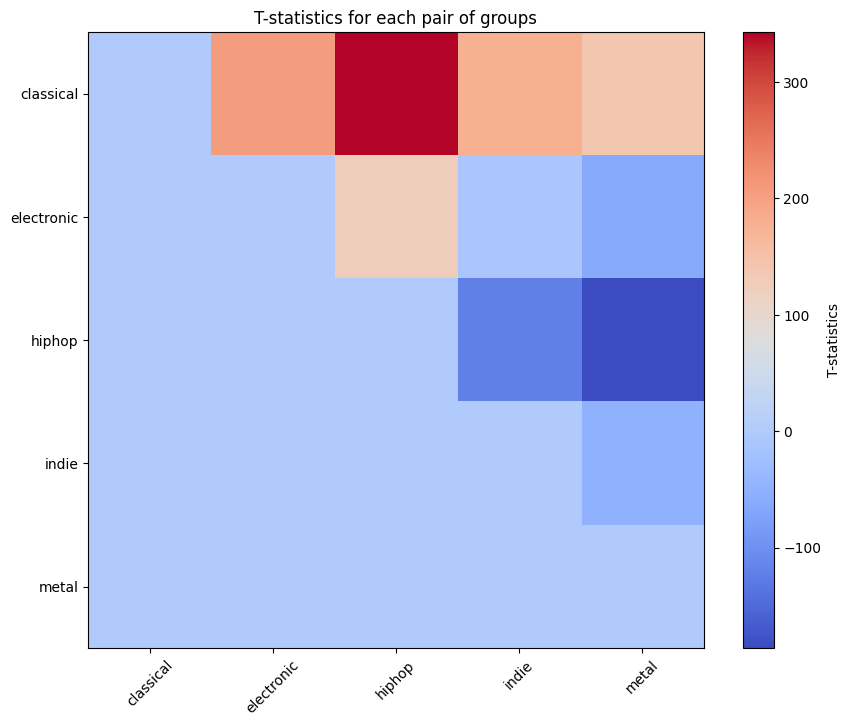

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t_stats is your t-statistics
t_stats = np.array(
    [
        [0, 205.48, 342.92, 179.01, 138.86],
        [0, 0, 125.23, -8.87, -63.86],
        [0, 0, 0, -121.54, -186.25],
        [0, 0, 0, 0, -49.07],
        [0, 0, 0, 0, 0],
    ]
)

labels = ["classical", "electronic", "hiphop", "indie", "metal"]

plt.figure(figsize=(10, 8))
plt.imshow(t_stats, cmap="coolwarm")
plt.colorbar(label="T-statistics")
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)
plt.title("T-statistics for each pair of groups")
plt.show()